In [1]:
import pandas as pd

data = pd.read_csv('cleaned.csv')
data.head()

,storypoint,sentiment,text,class
0,5,0.063889,Generic webwork aliases may clash plugins Some...,0
1,5,0.063889,Generic webwork aliases may clash plugins Some...,0
2,2,0.000000,Add text Agile Gadget Invalid Project message ...,0
3,2,0.000000,Add text Agile Gadget Invalid Project message ...,0
4,5,0.107576,Version set create issue screen JIRA GreenHopp...,0


In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hawkp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hawkp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

data['processed_text'] = data['text'].apply(preprocess_text)
data.head()

,storypoint,sentiment,text,class,processed_text
0,5,0.063889,Generic webwork aliases may clash plugins Some...,0,generic webwork aliases may clash plugins web ...
1,5,0.063889,Generic webwork aliases may clash plugins Some...,0,generic webwork aliases may clash plugins web ...
2,2,0.000000,Add text Agile Gadget Invalid Project message ...,0,add text agile gadget invalid project message ...
3,2,0.000000,Add text Agile Gadget Invalid Project message ...,0,add text agile gadget invalid project message ...
4,5,0.107576,Version set create issue screen JIRA GreenHopp...,0,version set create issue screen jira greenhopp...


In [4]:
import fasttext

# Save preprocessed text to a file as FastText expects file input
with open('preprocessed_text.txt', 'w') as f:
    for item in data['processed_text'].tolist():
        f.write('%s\n' % item)

# Train the FastText model
model = fasttext.train_unsupervised('preprocessed_text.txt')

# Let's see the embedding of a sample word 'project'
print(model['project'])

[-0.48717538 -0.06293322  0.18147032  0.13056554 -0.07494892 -0.07212879
  0.2015386   0.14203858 -0.13750927 -0.03098527  0.09638905 -0.24395503
 -0.4168806   0.49545988 -0.79972386  0.01706588 -0.2326653   0.35001996
 -0.1532671   0.25148958 -0.35036498 -0.06931615 -0.4384722   0.04848916
 -0.0714991  -0.07830384 -0.18356806  0.09204054  0.02743439  0.13786492
 -0.31791526  0.00558359 -0.4082227  -0.1494239   0.02581196 -0.07935595
  0.10135195  0.38455516  0.267086   -0.21474642  0.24403259  0.02848558
 -0.36254683 -0.08348499  0.23912618  0.15393817  0.4517555   0.5995889
  0.19151881  0.09041619 -0.04936492 -0.2045324  -0.26401067  0.23128626
  0.02390004  0.15423988 -0.00887669 -0.17818931 -0.7477868  -0.22201811
  0.21925707  0.02298299  0.00092903  0.24181189  0.04422707 -0.04388613
 -0.38963863 -0.39566332 -0.2552814   0.65251315  0.30780202 -0.06667045
  0.1253015  -0.11500777 -0.012413   -0.1502553   0.23092784  0.24710104
 -0.24315938  0.30209535  0.43959996  0.02598473 -0.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Initialize TfidfVectorizer with the same tokenizer we used for FastText
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
# Fit and transform the vectorizer on our corpus
tfidf_matrix = vectorizer.fit_transform(data['processed_text'])
# Get the words in our corpus
words = vectorizer.get_feature_names_out()
# Get the FastText embeddings for each word in our corpus
embeddings = np.array([model.get_word_vector(word) for word in words])
# Multiply the TF-IDF matrix by the embeddings to get the weighted embeddings
weighted_embeddings = tfidf_matrix @ embeddings
print('Shape of weighted embeddings:', weighted_embeddings.shape)

c:\Users\hawkp\miniconda3\envs\agile\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Shape of weighted embeddings: (56325, 100)


In [6]:
from sklearn.model_selection import train_test_split

X = weighted_embeddings
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of training data:', X_train.shape)
print('Shape of testing data:', X_test.shape)

Shape of training data: (45060, 100)
Shape of testing data: (11265, 100)


In [7]:
import torch
from sklearn.model_selection import train_test_split

# Convert the embeddings and labels into PyTorch tensors
X = torch.tensor(weighted_embeddings, dtype=torch.float)
y = torch.tensor(data['class'].values, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of training data:', X_train.shape)
print('Shape of testing data:', X_test.shape)

Shape of training data: torch.Size([45060, 100])
Shape of testing data: torch.Size([11265, 100])


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Create data loaders
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [9]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    for data, target in data_loader:
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [10]:
def test(model, criterion, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data.unsqueeze(1))
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(data_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

def evaluate(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist())
            y_pred.extend(pred.squeeze(1).tolist())

    print(f'Accuracy:{accuracy_score(y_true, y_pred)}')
    print()
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    print()
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(y_true, y_pred, [0,1,2])

In [12]:
from torch import nn, optim

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the models
rnn = RNN(input_size=100, hidden_size=50, num_classes=3)
lstm = LSTM(input_size=100, hidden_size=50, num_classes=3)

# Print the models
print('RNN Model:', rnn)
print()
print('LSTM Model:', lstm)

RNN Model: RNN(
  (rnn): RNN(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

LSTM Model: LSTM(
  (lstm): LSTM(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [13]:
# Define the loss function and the optimizers
criterion = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn.parameters())
optimizer_lstm = optim.Adam(lstm.parameters())

Training RNN...
Testing RNN...
Test set: Average loss: 0.0033, Accuracy: 7157/11265 (64%)

Evaluating RNN...
Accuracy:0.6353306702174878

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      3768
           1       0.55      0.53      0.54      3754
           2       0.70      0.70      0.70      3743

    accuracy                           0.64     11265
   macro avg       0.63      0.64      0.63     11265
weighted avg       0.63      0.64      0.63     11265


Confusion Matrix:
[[2553  913  302]
 [ 949 2001  804]
 [ 414  726 2603]]



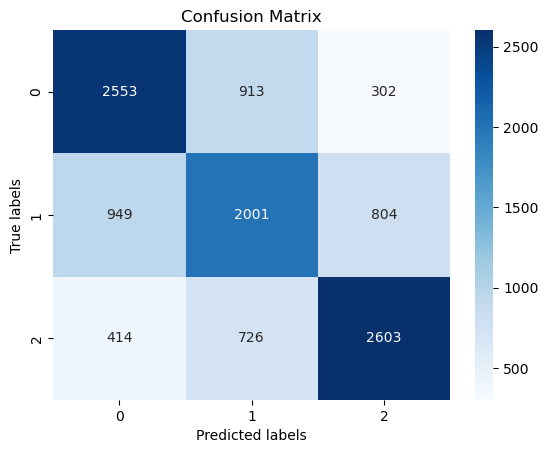

In [14]:
# Train, test and evaluate the RNN model
print('Training RNN...')
train(rnn, optimizer_rnn, criterion, train_loader)
print('Testing RNN...')
test(rnn, criterion, test_loader)
print('Evaluating RNN...')
evaluate(rnn, test_loader)

Training LSTM...
Testing LSTM...
Test set: Average loss: 0.0031, Accuracy: 7448/11265 (66%)

Evaluating LSTM...
Accuracy:0.6611628939192188

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.69      3768
           1       0.60      0.48      0.53      3754
           2       0.73      0.75      0.74      3743

    accuracy                           0.66     11265
   macro avg       0.66      0.66      0.66     11265
weighted avg       0.66      0.66      0.66     11265


Confusion Matrix:
[[2828  690  250]
 [1136 1805  813]
 [ 412  516 2815]]



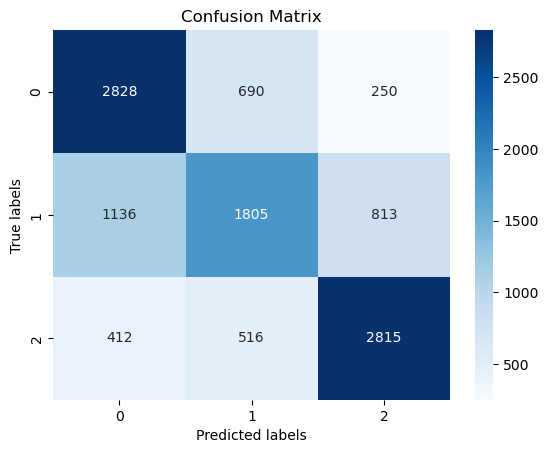

In [15]:
# Train, test and evaluate the LSTM model
print('Training LSTM...')
train(lstm, optimizer_lstm, criterion, train_loader)
print('Testing LSTM...')
test(lstm, criterion, test_loader)
print('Evaluating LSTM...')
evaluate(lstm, test_loader)

In [16]:
# Define the GRU model
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out
    
# Initialize the model
gru = GRU(input_size=100, hidden_size=50, num_classes=3)

# Print the model
print('GRU Model:', gru)

GRU Model: GRU(
  (gru): GRU(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [17]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(gru.parameters())

Training GRU...
Testing GRU...
Test set: Average loss: 0.0031, Accuracy: 7247/11265 (64%)

Evaluating GRU...
Accuracy:0.6433200177541056

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      3768
           1       0.55      0.53      0.54      3754
           2       0.67      0.76      0.72      3743

    accuracy                           0.64     11265
   macro avg       0.64      0.64      0.64     11265
weighted avg       0.64      0.64      0.64     11265


Confusion Matrix:
[[2405  986  377]
 [ 759 1988 1007]
 [ 281  608 2854]]



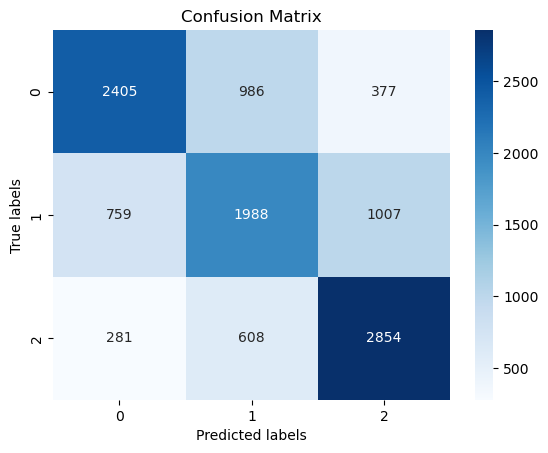

In [18]:
# Train and test the GRU model
print('Training GRU...')
train(gru, optimizer_gru, criterion, train_loader)
print('Testing GRU...')
test(gru, criterion, test_loader)
print('Evaluating GRU...')
evaluate(gru, test_loader)

In [19]:
# Define the BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
        
# Initialize the model
bilstm = BiLSTM(input_size=100, hidden_size=50, num_classes=3)

# Print the model
print('BiLSTM Model:', bilstm)

BiLSTM Model: BiLSTM(
  (lstm): LSTM(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [20]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bilstm = optim.Adam(bilstm.parameters())

Training BiLSTM...
Testing BiLSTM...
Test set: Average loss: 0.0030, Accuracy: 7518/11265 (67%)

Evaluating BiLSTM...
Accuracy:0.6673768308921438

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      3768
           1       0.56      0.63      0.59      3754
           2       0.79      0.64      0.71      3743

    accuracy                           0.67     11265
   macro avg       0.68      0.67      0.67     11265
weighted avg       0.68      0.67      0.67     11265


Confusion Matrix:
[[2762  858  148]
 [ 914 2352  488]
 [ 337 1002 2404]]



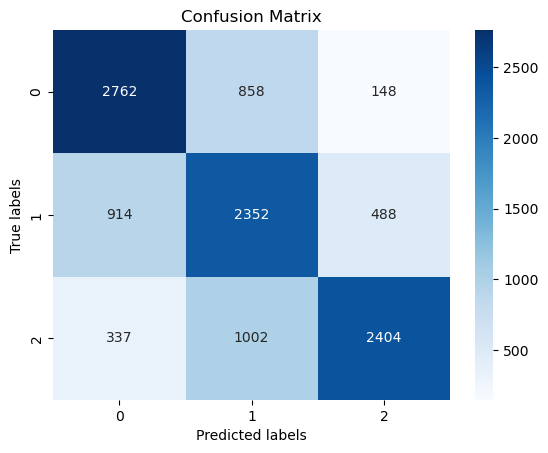

In [21]:
# Train and test the BiLSTM model
print('Training BiLSTM...')
train(bilstm, optimizer_bilstm, criterion, train_loader)
print('Testing BiLSTM...')
test(bilstm, criterion, test_loader)
print('Evaluating BiLSTM...')
evaluate(bilstm, test_loader)

In [22]:
# Define the BiGRU model
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out
            
# Initialize the model
bigru = BiGRU(input_size=100, hidden_size=50, num_classes=3)

# Print the model
print('BiGRU Model:', bigru)

BiGRU Model: BiGRU(
  (gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [23]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bigru = optim.Adam(bigru.parameters())

Training BiGRU...
Testing BiGRU...
Test set: Average loss: 0.0030, Accuracy: 7509/11265 (67%)

Evaluating BiGRU...
Accuracy:0.6665778961384821

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      3768
           1       0.61      0.49      0.55      3754
           2       0.69      0.75      0.72      3743

    accuracy                           0.67     11265
   macro avg       0.66      0.67      0.66     11265
weighted avg       0.66      0.67      0.66     11265


Confusion Matrix:
[[2838  614  316]
 [ 966 1848  940]
 [ 370  550 2823]]



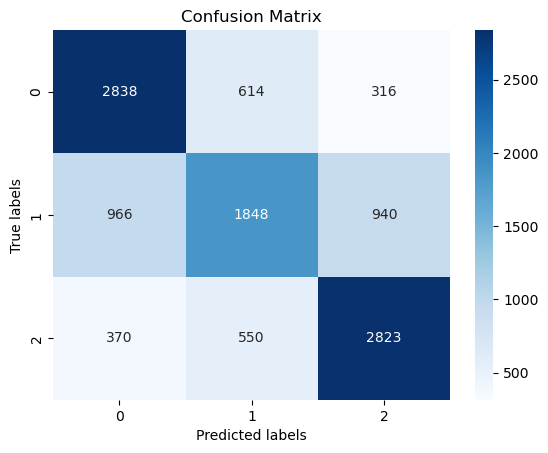

In [24]:
# Train and test the BiGRU model
print('Training BiGRU...')
train(bigru, optimizer_bigru, criterion, train_loader)
print('Testing BiGRU...')
test(bigru, criterion, test_loader)

print('Evaluating BiGRU...')
evaluate(bigru, test_loader)

In [25]:
import torch.nn.functional as F

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.fc = nn.Linear(100 * 24, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = out.view(-1, 100 * 24)
        out = self.fc(out)
        return out
        
# Initialize the model
cnn = CNN(num_classes=3)

# Print the model
print('CNN Model:', cnn)

CNN Model: CNN(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=2400, out_features=3, bias=True)
)


In [26]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters())

In [27]:
# Train and test the CNN model
print('Training CNN...')
train(cnn, optimizer_cnn, criterion, train_loader)
print('Testing CNN...')
test(cnn, criterion, test_loader)

print('Evaluating CNN...')
evaluate(cnn, test_loader)

Training CNN...


ValueError: Expected input batch_size (1024) to match target batch_size (256).

In [28]:
# Define the CNN-LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True)
        self.fc = nn.Linear(50, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out
            
# Initialize the model
cnn_lstm = CNN_LSTM(num_classes=3)

# Print the model
print('CNN-LSTM Model:', cnn_lstm)

CNN-LSTM Model: CNN_LSTM(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [29]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_lstm = optim.Adam(cnn_lstm.parameters())

In [30]:
# Train and test the CNN-LSTM model
print('Training CNN-LSTM...')
train(cnn_lstm, optimizer_cnn_lstm, criterion, train_loader)
print('Testing CNN-LSTM...')
test(cnn_lstm, criterion, test_loader)

print('Evaluating CNN-LSTM...')
evaluate(cnn_lstm, test_loader)

Training CNN-LSTM...


RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 96

In [31]:
# Define the CNN-BiLSTM model
class CNN_BiLSTM(nn.Module):            
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out
                
# Initialize the model
cnn_bilstm = CNN_BiLSTM(num_classes=3)

# Print the model
print('CNN-BiLSTM Model:', cnn_bilstm)

CNN-BiLSTM Model: CNN_BiLSTM(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [32]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_bilstm = optim.Adam(cnn_bilstm.parameters())

In [33]:
# Train and test the CNN-BiLSTM model
print('Training CNN-BiLSTM...')
train(cnn_bilstm, optimizer_cnn_bilstm, criterion, train_loader)
print('Testing CNN-BiLSTM...')
test(cnn_bilstm, criterion, test_loader)

print('Evaluating CNN-BiLSTM...')
evaluate(cnn_bilstm, test_loader)

Training CNN-BiLSTM...


RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 96

In [34]:
# Define the CNN-GRU model
class CNN_GRU(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.gru = nn.GRU(100, 50, batch_first=True)
        self.fc = nn.Linear(50, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out
                        
# Initialize the model
cnn_gru = CNN_GRU(num_classes=3)

# Print the model
print('CNN-GRU Model:', cnn_gru)

CNN-GRU Model: CNN_GRU(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (gru): GRU(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)


In [35]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_gru = optim.Adam(cnn_gru.parameters())

In [36]:
# Train and test the CNN-GRU model
print('Training CNN-GRU...')
train(cnn_gru, optimizer_cnn_gru, criterion, train_loader)
print('Testing CNN-GRU...')
test(cnn_gru, criterion, test_loader)

print('Evaluating CNN-GRU...')
evaluate(cnn_gru, test_loader)

Training CNN-GRU...


RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 96

In [37]:
# Define the CNN-BiGRU model
class CNN_BiGRU(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiGRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.gru = nn.GRU(100, 50, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out
                                    
# Initialize the model
cnn_bigru = CNN_BiGRU(num_classes=3)

# Print the model
print('CNN-BiGRU Model:', cnn_bigru)

CNN-BiGRU Model: CNN_BiGRU(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
  (gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [38]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_bigru = optim.Adam(cnn_bigru.parameters())

In [39]:
# Train and test the CNN-BiGRU model
print('Training CNN-BiGRU...')
train(cnn_bigru, optimizer_cnn_bigru, criterion, train_loader)
print('Testing CNN-BiGRU...')
test(cnn_bigru, criterion, test_loader)

print('Evaluating CNN-BiGRU...')
evaluate(cnn_bigru, test_loader)

Training CNN-BiGRU...


RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 96

In [ ]:
# Define the CNN-LSTM-GRU model
class CNN_LSTM_GRU(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM_GRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True)
        self.gru = nn.GRU(50, 50, batch_first=True)
        self.fc = nn.Linear(50, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out
                                            
# Initialize the model
cnn_lstm_gru = CNN_LSTM_GRU(num_classes=3)

# Print the model
print('CNN-LSTM-GRU Model:', cnn_lstm_gru)

In [ ]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_lstm_gru = optim.Adam(cnn_lstm_gru.parameters())

In [ ]:
# Train and test the CNN-LSTM-GRU model
print('Training CNN-LSTM-GRU...')
train(cnn_lstm_gru, optimizer_cnn_lstm_gru, criterion, train_loader)

print('Testing CNN-LSTM-GRU...')
test(cnn_lstm_gru, criterion, test_loader)

print('Evaluating CNN-LSTM-GRU...')
evaluate(cnn_lstm_gru, test_loader)

In [ ]:
# Define the CNN-LSTM-BiGRU model
class CNN_LSTM_BiGRU(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM_BiGRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True)
        self.gru = nn.GRU(50, 50, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out}
                                                    
# Initialize the model
cnn_lstm_bigru = CNN_LSTM_BiGRU(num_classes=3)

# Print the model
print('CNN-LSTM-BiGRU Model:', cnn_lstm_bigru)

In [ ]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_lstm_bigru = optim.Adam(cnn_lstm_bigru.parameters())

In [ ]:
# Train and test the CNN-LSTM-BiGRU model
print('Training CNN-LSTM-BiGRU...')
train(cnn_lstm_bigru, optimizer_cnn_lstm_bigru, criterion, train_loader)

print('Testing CNN-LSTM-BiGRU...')
test(cnn_lstm_bigru, criterion, test_loader)
print('Evaluating CNN-LSTM-BiGRU...')
evaluate(cnn_lstm_bigru, test_loader)

In [ ]:
# Define the CNN-BiLSTM-GRU model
class CNN_BiLSTM_GRU(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM_GRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(100, 50, batch_first=True)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out
                                                            
# Initialize the model
cnn_bilstm_gru = CNN_BiLSTM_GRU(num_classes=3)

# Print the model
print('CNN-BiLSTM-GRU Model:', cnn_bilstm_gru)

In [ ]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_bilstm_gru = optim.Adam(cnn_bilstm_gru.parameters())

In [ ]:
# Train and test the CNN-BiLSTM-GRU model
print('Training CNN-BiLSTM-GRU...')
train(cnn_bilstm_gru, optimizer_cnn_bilstm_gru, criterion, train_loader)

print('Testing CNN-BiLSTM-GRU...')
test(cnn_bilstm_gru, criterion, test_loader)

print('Evaluating CNN-BiLSTM-GRU...')
evaluate(cnn_bilstm_gru, test_loader)

In [ ]:
# Define the CNN-BiLSTM-BiGRU model
class CNN_BiLSTM_BiGRU(nn.Module):                                               
    def __init__(self, num_classes):
        super(CNN_BiLSTM_BiGRU, self).__init__()
        self.conv1 = nn.Conv1d(1, 50, 3)
        self.conv2 = nn.Conv1d(50, 100, 3)
        self.lstm = nn.LSTM(100, 50, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(100, 50, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out, _ = self.lstm(out)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out
                                                                        
# Initialize the model
cnn_bilstm_bigru = CNN_BiLSTM_BiGRU(num_classes=3)

# Print the model
print('CNN-BiLSTM-BiGRU Model:', cnn_bilstm_bigru)

In [ ]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn_bilstm_bigru = optim.Adam(cnn_bilstm_bigru.parameters())

In [ ]:
# Train and test the CNN-BiLSTM-BiGRU model
print('Training CNN-BiLSTM-BiGRU...')
train(cnn_bilstm_bigru, optimizer_cnn_bilstm_bigru, criterion, train_loader)

print('Testing CNN-BiLSTM-BiGRU...')
test(cnn_bilstm_bigru, criterion, test_loader)

print('Evaluating CNN-BiLSTM-BiGRU...')
evaluate(cnn_bilstm_bigru, test_loader)